# Evaluation in Numbers

## Imports

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import torch
from sklearn.metrics import (
    accuracy_score,
    confusion_matrix,
    f1_score,
)

from src.const.maps import EMOTION_MAP
from src.const.paths import (
    DATA_PATHS,
    MODELS_DIR,
    SPLIT_CSV,
)
from src.models.evaluate import evaluate_models
from src.models.trainer import EmotionClassifier

In [2]:
CKPT_FROZEN = MODELS_DIR / "mobilenet_v3_kdef-frozen-epoch=10-val_f1=0.64.ckpt"
CKPT_UNFROZEN = MODELS_DIR / "mobilenet_v3_kdef-unfrozen-epoch=13-val_f1=0.92.ckpt"

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

## Load Data and Models

In [3]:
df_master = pd.read_csv(SPLIT_CSV)
df_test = df_master[df_master["split"] == "test"].copy()

print(f"Images in test set: {len(df_test)}")
print(f"Unique subjects in test set: {df_test['subject_id'].unique()}")

Images in test set: 377
Unique subjects in test set: ['F01' 'F05' 'F10' 'F13' 'F31' 'M01' 'M15' 'M24' 'M28']


In [4]:
model_frozen = EmotionClassifier.load_from_checkpoint(CKPT_FROZEN)
model_frozen.to(device)
model_frozen.eval()

model_unfrozen = EmotionClassifier.load_from_checkpoint(CKPT_UNFROZEN)
model_unfrozen.to(device)
model_unfrozen.eval()

INFO: Backbone frozen. Training classifier head only.


## Evaluate

In [5]:
res_df = evaluate_models(
    df_test,
    device,
    model_frozen,
    model_unfrozen,
)
res_df.to_csv("outputs/evaluation_results.csv", index=False)

PyTorch Original:   0%|          | 0/12 [00:00<?, ?it/s]

DeepFace Original:   0%|          | 0/377 [00:00<?, ?it/s]

PyTorch Grayscale:   0%|          | 0/12 [00:00<?, ?it/s]

DeepFace Grayscale:   0%|          | 0/377 [00:00<?, ?it/s]

PyTorch Degraded:   0%|          | 0/12 [00:00<?, ?it/s]

DeepFace Degraded:   0%|          | 0/377 [00:00<?, ?it/s]

In [6]:
def calculate_metrics(df):
    df = df[df["pred"] != -1]
    if len(df) == 0:
        return 0.0, 0.0

    acc = accuracy_score(df["true"], df["pred"])
    f1 = f1_score(df["true"], df["pred"], average="macro")
    return acc, f1

In [7]:
metrics_data = []
models_list = ["frozen", "unfrozen", "deepface"]

for model_name in models_list:
    col_name = f"pred_{model_name}"

    for domain in DATA_PATHS.keys():
        subset = res_df[res_df["domain"] == domain].copy()
        subset = subset.rename(columns={col_name: "pred", "true_idx": "true"})

        acc, f1 = calculate_metrics(subset)

        metrics_data.append(
            {
                "Model": model_name.capitalize(),
                "Domain": domain,
                "Accuracy": acc,
                "F1-Score": f1,
            }
        )

## Metrics over Models and Data Types

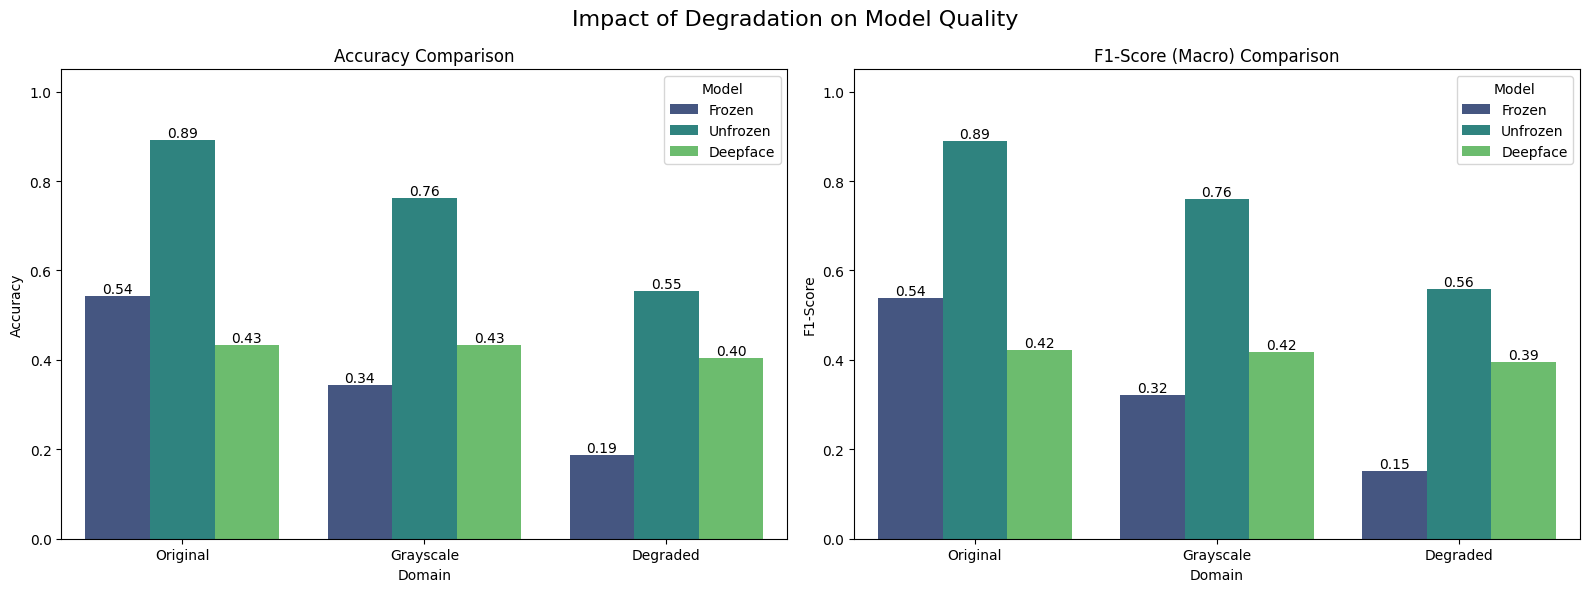

In [8]:
metrics_df = pd.DataFrame(metrics_data)

fig, axes = plt.subplots(1, 2, figsize=(16, 6))

sns.barplot(
    data=metrics_df,
    x="Domain",
    y="Accuracy",
    hue="Model",
    ax=axes[0],
    palette="viridis",
)
axes[0].set_title("Accuracy Comparison")
axes[0].set_ylim(0, 1.05)
for container in axes[0].containers:
    axes[0].bar_label(container, fmt="%.2f")

sns.barplot(
    data=metrics_df,
    x="Domain",
    y="F1-Score",
    hue="Model",
    ax=axes[1],
    palette="viridis",
)
axes[1].set_title("F1-Score (Macro) Comparison")
axes[1].set_ylim(0, 1.05)
for container in axes[1].containers:
    axes[1].bar_label(container, fmt="%.2f")

plt.suptitle("Impact of Degradation on Model Quality", fontsize=16)
plt.tight_layout()
plt.show()

In [9]:
def plot_confusion_matrix(df, model_col, domain, ax):
    subset = df[df["domain"] == domain]
    subset = subset[subset[model_col] != -1]

    cm = confusion_matrix(subset["true_idx"], subset[model_col], labels=list(range(7)))

    sns.heatmap(
        cm,
        annot=True,
        fmt="d",
        cmap="Blues",
        ax=ax,
        cbar=False,
        xticklabels=EMOTION_MAP.keys(),  # type: ignore
        yticklabels=EMOTION_MAP.keys(),  # type: ignore
    )
    ax.set_title(f"{model_col.split('_')[1].upper()} on {domain}")
    ax.set_ylabel("True")
    ax.set_xlabel("Pred")

### Confusion Matrices

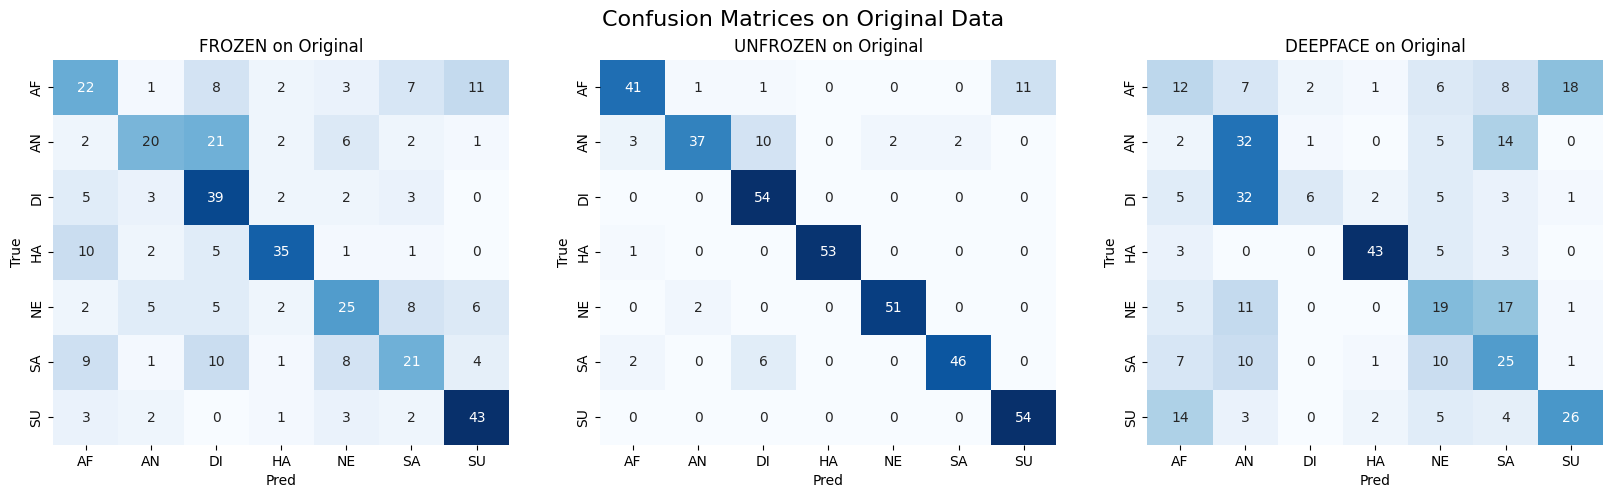

In [10]:
fig, axes = plt.subplots(1, 3, figsize=(20, 5))

plot_confusion_matrix(res_df, "pred_frozen", "Original", axes[0])
plot_confusion_matrix(res_df, "pred_unfrozen", "Original", axes[1])
plot_confusion_matrix(res_df, "pred_deepface", "Original", axes[2])

plt.suptitle("Confusion Matrices on Original Data", fontsize=16)
plt.show()

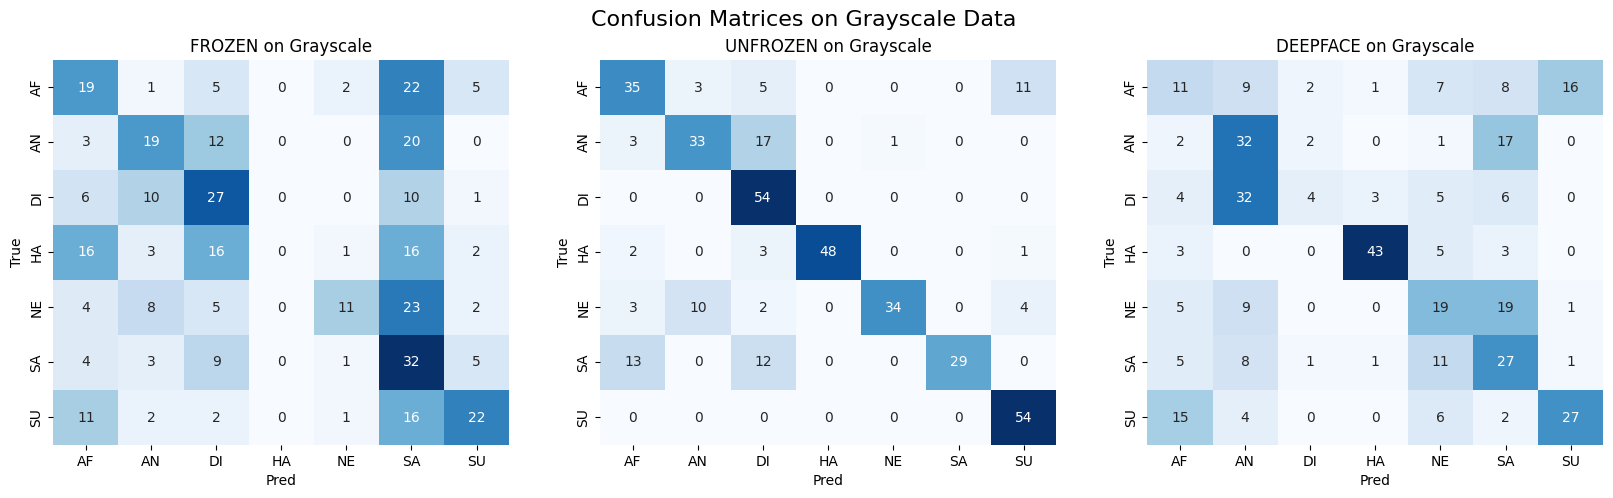

In [11]:
fig, axes = plt.subplots(1, 3, figsize=(20, 5))

plot_confusion_matrix(res_df, "pred_frozen", "Grayscale", axes[0])
plot_confusion_matrix(res_df, "pred_unfrozen", "Grayscale", axes[1])
plot_confusion_matrix(res_df, "pred_deepface", "Grayscale", axes[2])

plt.suptitle("Confusion Matrices on Grayscale Data", fontsize=16)
plt.show()

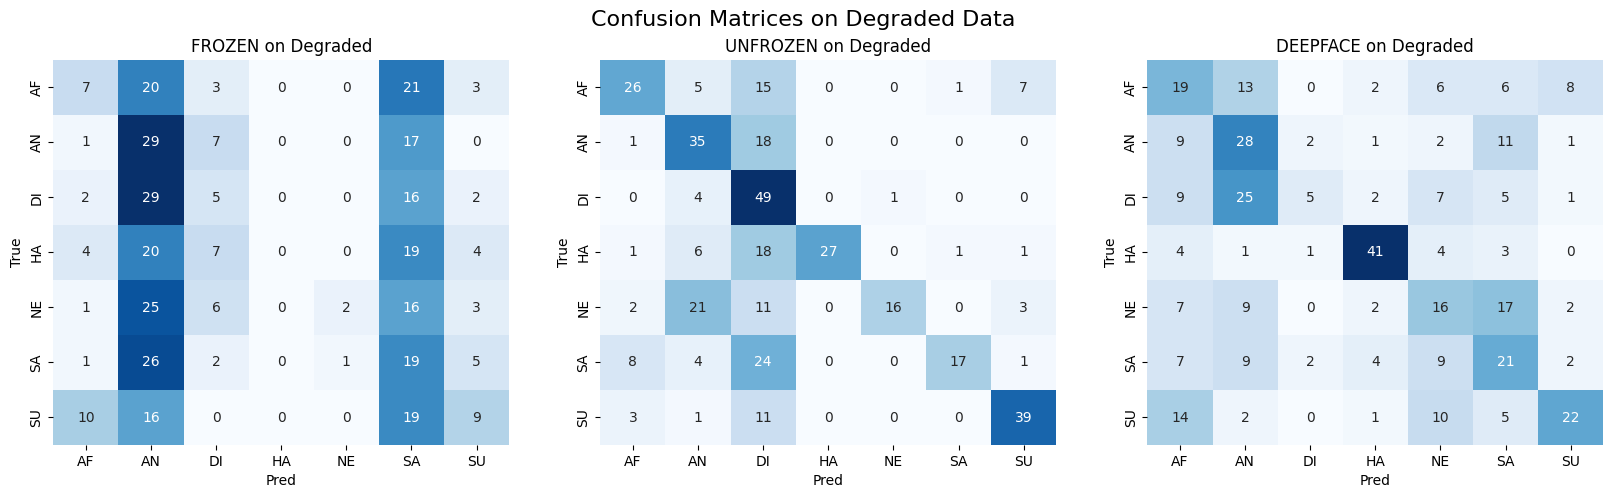

In [12]:
fig, axes = plt.subplots(1, 3, figsize=(20, 5))

plot_confusion_matrix(res_df, "pred_frozen", "Degraded", axes[0])
plot_confusion_matrix(res_df, "pred_unfrozen", "Degraded", axes[1])
plot_confusion_matrix(res_df, "pred_deepface", "Degraded", axes[2])

plt.suptitle("Confusion Matrices on Degraded Data", fontsize=16)
plt.show()

In [13]:
res_df["Gender"] = res_df["subject"].apply(
    lambda x: "Female" if "F" in str(x) else "Male"
)


def plot_gender_bias(df, model_col):
    bias_df = (
        df.groupby(["domain", "Gender"])
        .apply(lambda x: f1_score(x["true_idx"], x[model_col], average="macro"))
        .reset_index(name="F1-Score")
    )

    plt.figure(figsize=(10, 6))
    sns.barplot(data=bias_df, x="domain", y="F1-Score", hue="Gender", palette="pastel")
    plt.title(f"Gender Bias Analysis: {model_col}")
    plt.ylim(0, 1.0)
    plt.show()

## Gender Bias

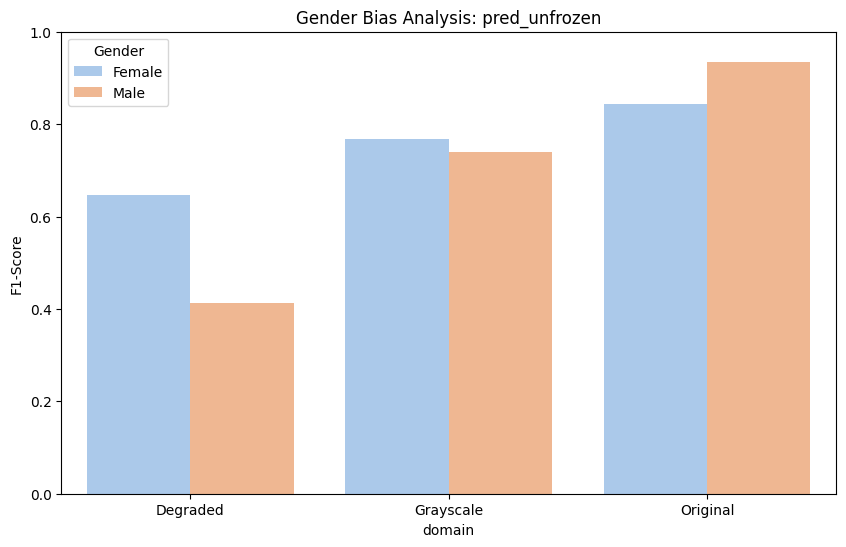

In [14]:
plot_gender_bias(res_df, "pred_unfrozen")

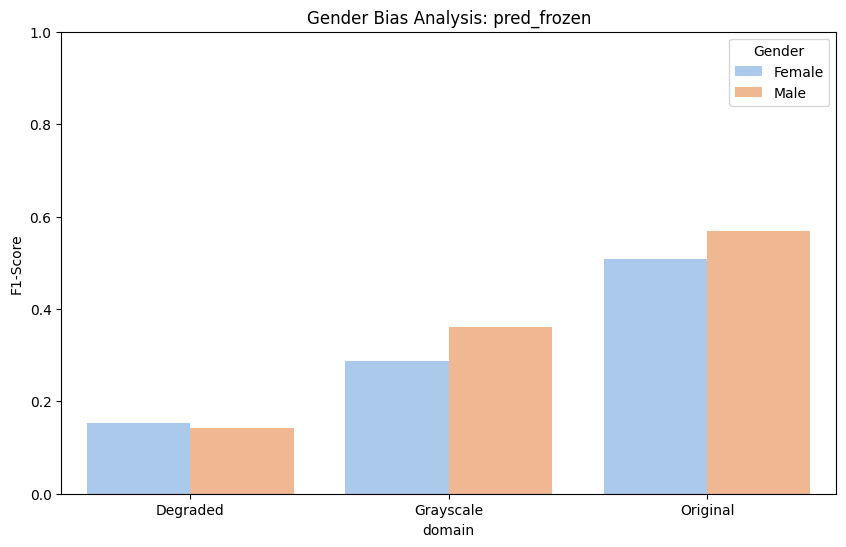

In [15]:
plot_gender_bias(res_df, "pred_frozen")

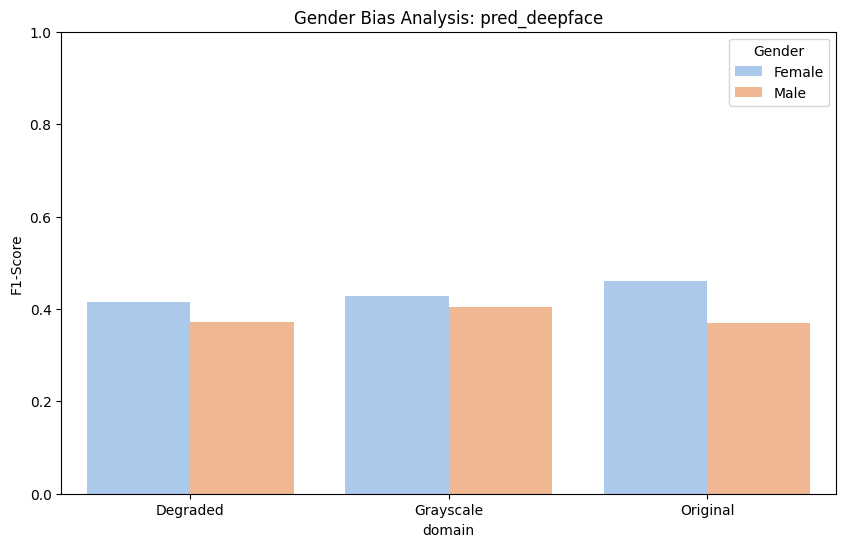

In [16]:
plot_gender_bias(res_df, "pred_deepface")